In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# 1. IMPORT LIBRARIES
# ======================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)


In [20]:
# ======================================================
# 2. LOAD DATASET
# ======================================================
train = pd.read_csv("/kaggle/input/yashdataset02/train (1).csv")
test  = pd.read_csv("/kaggle/input/yashdataset02/test (1).csv")

TARGET = "Status"


In [4]:
train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,1481.0,Placebo,12963.0,F,N,Y,N,N,2.4,346.0,3.34,70.0,1212.0,122.45,118.0,117.0,12.2,4.0,C
1,1,2580.0,D-penicillamine,20819.0,F,N,N,N,N,0.6,NaN,4.52,51.0,645.0,74.40,NaN,181.0,10.4,3.0,C
2,2,837.0,D-penicillamine,12307.0,F,N,Y,Y,N,6.1,586.0,2.73,89.0,2045.0,196.85,90.0,228.0,10.4,3.0,D
3,3,3021.0,NaN,17532.0,F,NaN,NaN,NaN,N,0.6,NaN,3.34,NaN,NaN,NaN,NaN,388.0,10.4,3.0,C
4,4,1980.0,NaN,23011.0,F,NaN,NaN,NaN,N,0.8,NaN,3.65,NaN,NaN,NaN,NaN,190.0,11.1,4.0,C


In [5]:
test.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,15000,1614.0,Placebo,21281.0,F,N,N,N,N,0.6,257.0,3.50,44.0,1345.0,93.00,68.0,NaN,9.7,4.0
1,15001,2573.0,D-penicillamine,20834.0,F,N,N,N,N,0.6,217.0,4.19,13.0,678.0,45.00,75.0,356.0,9.6,3.0
2,15002,1367.0,NaN,23011.0,F,NaN,NaN,NaN,N,0.8,NaN,3.03,NaN,NaN,NaN,NaN,312.0,10.6,2.0
3,15003,1080.0,Placebo,15895.0,M,N,N,N,N,2.3,201.0,3.55,44.0,1623.0,237.15,56.0,224.0,13.6,2.0
4,15004,3853.0,Placebo,14872.0,F,N,N,N,N,0.7,259.0,3.77,44.0,685.0,97.65,93.0,249.0,11.0,1.0


In [24]:
# ===================== BASIC CLEANING =====================
train = train.drop_duplicates()
test  = test.drop_duplicates()
# ======================================================
# 3. DATA CLEANING & PREPROCESSING
# ======================================================
# Drop duplicates
train.drop_duplicates(inplace=True)

# Drop high-cardinality / irrelevant columns
# drop_cols = ["Name", "Ticket", "Cabin"]
# train.drop(columns=drop_cols, inplace=True, errors="ignore")
# test.drop(columns=drop_cols, inplace=True, errors="ignore")


# Separate numerical & categorical columns
num_cols = train.select_dtypes(include=["int64","float64"]).columns
cat_cols = train.select_dtypes(include=["object"]).columns.drop(TARGET)

# Handle missing values
train[num_cols] = train[num_cols].fillna(train[num_cols].median())
test[num_cols]  = test[num_cols].fillna(test[num_cols].median())

train[cat_cols] = train[cat_cols].fillna(train[cat_cols].mode().iloc[0])
test[cat_cols]  = test[cat_cols].fillna(test[cat_cols].mode().iloc[0])


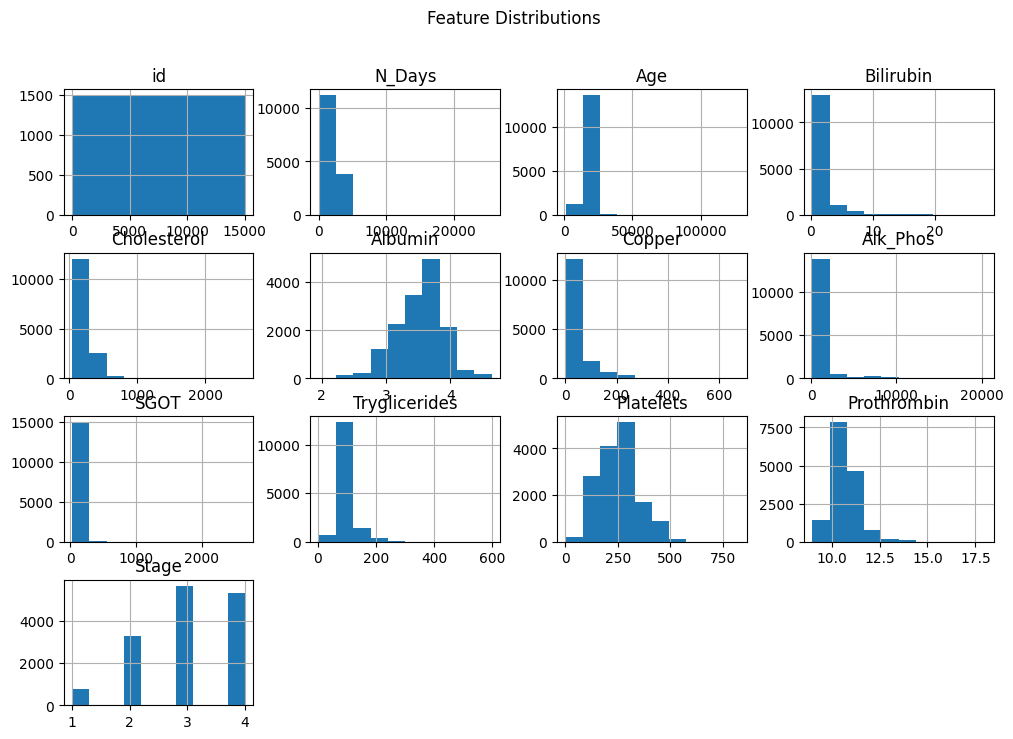

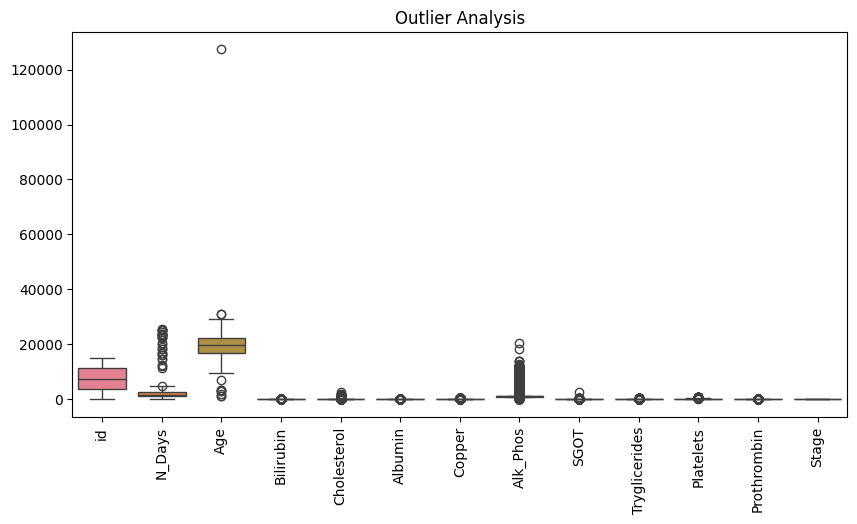

In [25]:
# ======================================================
# 4. DATA VISUALIZATION & OUTLIER ANALYSIS
# ======================================================
train[num_cols].hist(figsize=(12,8))
plt.suptitle("Feature Distributions")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=train[num_cols])
plt.title("Outlier Analysis")
plt.xticks(rotation=90)
plt.show()

In [30]:
# ======================================================
# 5. ENCODING CATEGORICAL VARIABLES
# ======================================================
# for col in cat_cols:
#     le = LabelEncoder()
#     train[col] = le.fit_transform(train[col])
#     test[col]  = le.transform(test[col])
from sklearn.preprocessing import LabelEncoder

for col in cat_cols:
    # force everything to string
    train[col] = train[col].astype(str)
    test[col]  = test[col].astype(str)
    
    le = LabelEncoder()
    combined = pd.concat([train[col], test[col]], axis=0)
    le.fit(combined)
    
    train[col] = le.transform(train[col])
    test[col]  = le.transform(test[col])



In [37]:
# ======================================================
# 7. FEATURE SCALING
# ======================================================
X = train.drop(TARGET, axis=1)
y = train[TARGET]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test)


In [40]:
# ======================================================
# 8. TRAIN–TEST SPLIT
# ======================================================
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [43]:
# ======================================================
# 9. MODEL TRAINING
# ======================================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True)
}


In [44]:
# ======================================================
# 10. MODEL EVALUATION
# ======================================================
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    print(f"\n🔹 {name}")
    print("Accuracy :", accuracy_score(y_val, preds))
    print("Precision:", precision_score(y_val, preds, average="weighted"))
    print("Recall   :", recall_score(y_val, preds, average="weighted"))
    print("F1 Score :", f1_score(y_val, preds, average="weighted"))
    print("Confusion Matrix:\n", confusion_matrix(y_val, preds))
    print("Classification Report:\n", classification_report(y_val, preds))



🔹 Logistic Regression
Accuracy : 0.8293333333333334
Precision: 0.8080016808492109
Recall   : 0.8293333333333334
F1 Score : 0.8141413331884878
Confusion Matrix:
 [[1901    0  122]
 [  56    0   18]
 [ 312    4  587]]
Classification Report:
               precision    recall  f1-score   support

           C       0.84      0.94      0.89      2023
          CL       0.00      0.00      0.00        74
           D       0.81      0.65      0.72       903

    accuracy                           0.83      3000
   macro avg       0.55      0.53      0.54      3000
weighted avg       0.81      0.83      0.81      3000


🔹 KNN
Accuracy : 0.814
Precision: 0.7976168411017808
Recall   : 0.814
F1 Score : 0.8004454253086232
Confusion Matrix:
 [[1865    3  155]
 [  55    2   17]
 [ 324    4  575]]
Classification Report:
               precision    recall  f1-score   support

           C       0.83      0.92      0.87      2023
          CL       0.22      0.03      0.05        74
           D    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [45]:
# ======================================================
# 11. HYPER-PARAMETER TUNING (RANDOM FOREST)
# ======================================================
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring="f1_weighted",
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_rf = grid.best_estimator_

print("\nBest Random Forest Parameters:", grid.best_params_)



Best Random Forest Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}


In [46]:
# ======================================================
# 12. FINAL MODEL EVALUATION
# ======================================================
final_preds = best_rf.predict(X_val)
print("\nFinal Tuned Random Forest Performance")
print(classification_report(y_val, final_preds))



Final Tuned Random Forest Performance
              precision    recall  f1-score   support

           C       0.86      0.94      0.90      2023
          CL       0.60      0.04      0.08        74
           D       0.82      0.71      0.76       903

    accuracy                           0.85      3000
   macro avg       0.76      0.56      0.58      3000
weighted avg       0.84      0.85      0.84      3000



In [48]:
# Predict class probabilities
proba = model.predict_proba(test)

# Create submission DataFrame
submission = pd.DataFrame({
    "id": test["id"],
    "Status_C":  proba[:, 0],
    "Status_CL": proba[:, 1],
    "Status_D":  proba[:, 2]
})

# Save file
submission.to_csv("submission.csv", index=False)

print("submission.csv generated successfully")


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


submission.csv generated successfully
